## Parse all images to text

merged: 20
filtered: 18
last_rect: 10
[[ 521  826]
 [1114  826]
 [1114  892]
 [ 521  892]]
[[140 458]
 [425 458]
 [425 684]
 [140 684]]
[[ 521  774]
 [1114  774]
 [1114  816]
 [ 521  816]]
[[514 422]
 [799 422]
 [799 472]
 [514 472]]
[[514 370]
 [799 370]
 [799 412]
 [514 412]]
[[515 536]
 [800 536]
 [800 577]
 [515 577]]
[[167 281]
 [398 281]
 [398 323]
 [167 323]]
[[168 804]
 [397 804]
 [397 846]
 [168 846]]
[[167 134]
 [398 134]
 [398 175]
 [167 175]]
[[ 559  993]
 [ 775  993]
 [ 775 1034]
 [ 559 1034]]
[[ 322  993]
 [ 522  993]
 [ 522 1035]
 [ 322 1035]]
[[  88  993]
 [ 280  993]
 [ 280 1034]
 [  88 1034]]
[[167 186]
 [398 186]
 [398 220]
 [167 220]]
[[516 589]
 [799 589]
 [799 605]
 [516 605]]
[[167 333]
 [398 333]
 [398 351]
 [167 351]]
[[ 559 1045]
 [ 775 1045]
 [ 775 1062]
 [ 559 1062]]
[[ 322 1045]
 [ 522 1045]
 [ 522 1063]
 [ 322 1063]]
[[  88 1045]
 [ 280 1045]
 [ 280 1063]
 [  88 1063]]
Cropped image saved to cropped_images/cropped_0.png
Cropped image saved to cropped_image

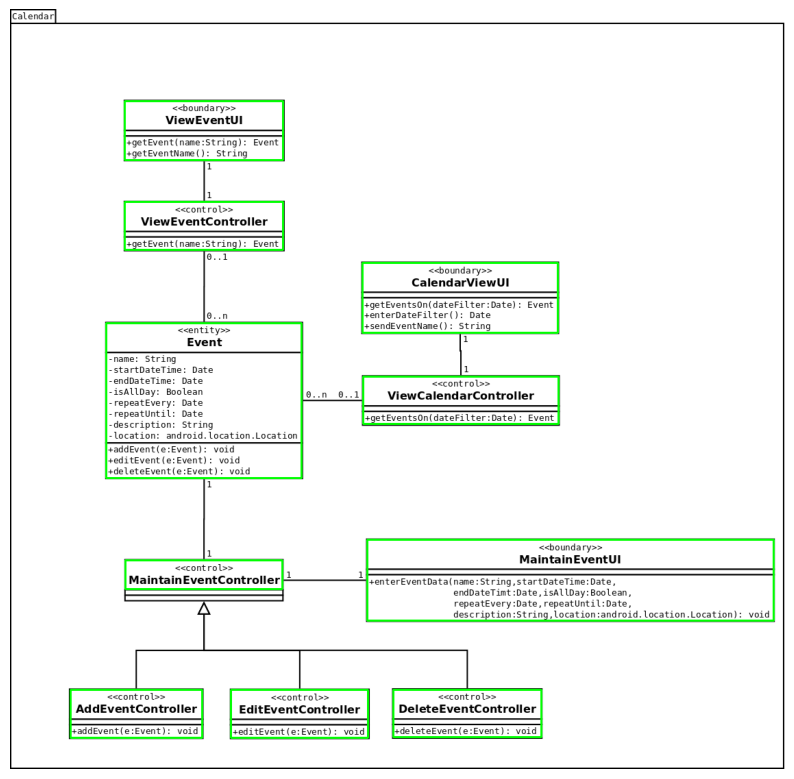

In [3]:
from pythonscript.rectangle_parser import run_parser
image_path = '/Users/elifnazduman/Desktop/E.D ÖZEL/python/uml-parser/uml.png'
run_parser(image_path)

## Save the text as file

In [ ]:
#Convert gif to png

import os
import imageio

# Define the directory containing GIF files
input_directory = '/Users/elifnazduman/Desktop/E.D ÖZEL/python/uml-parser/data_models/18_google-api-python-client'
output_directory = '/Users/elifnazduman/Desktop/E.D ÖZEL/python/uml-parser/data_models/18_google-api-python-client'

# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)

# Iterate over all files in the input directory
for filename in os.listdir(input_directory):
    if filename.lower().endswith('.gif'):
        gif_path = os.path.join(input_directory, filename)
        output_filename = os.path.splitext(filename)[0] + '.png'
        output_png_path = os.path.join(output_directory, output_filename)

        # Convert GIF to PNG
        gif = imageio.mimread(gif_path)
        imageio.mimsave(output_png_path, gif, format='PNG')
        print(f"Converted {gif_path} to {output_png_path}")

print("All GIF files have been converted to PNG.")

## Parse diagrams

In [3]:
# parsing code to extract JSON from UML diagrams

In [ ]:
#first, run uml_parser.py and then image_to_text.py

uml_parser.py

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
image_path = 'uml.png'
y_tolerance = 15
def save_list_to_txt(data, filename):
    with open(filename, mode='w') as file:
        for row in data:
            line = '\t'.join(map(str, row))
            file.write(line + '\n')


def angle_cos(p0, p1, p2):
    d1, d2 = (p0 - p1).astype(np.float32), (p2 - p1).astype(np.float32)
    return abs(np.dot(d1, d2) / np.sqrt(np.dot(d1, d1) * np.dot(d2, d2)))


def find_squares(img):
    img = cv2.GaussianBlur(img, (5, 5), 0)
    squares = []
    for gray in cv2.split(img):
        for thrs in range(0, 255, 26):
            if thrs == 0:
                bin = cv2.Canny(gray, 0, 50, apertureSize=5)
                bin = cv2.dilate(bin, None)
            else:
                _retval, bin = cv2.threshold(gray, thrs, 255, cv2.THRESH_BINARY)
            contours, _hierarchy = cv2.findContours(bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                cnt_len = cv2.arcLength(cnt, True)
                cnt = cv2.approxPolyDP(cnt, 0.02 * cnt_len, True)
                if len(cnt) == 4 and cv2.contourArea(cnt) > 1000 and cv2.isContourConvex(cnt):
                    cnt = cnt.reshape(-1, 2)
                    max_cos = np.max([angle_cos(cnt[i], cnt[(i + 1) % 4], cnt[(i + 2) % 4]) for i in range(4)])
                    if max_cos < 0.1:
                        squares.append(cnt)
    return squares

rectangles = find_squares(cv2.imread(image_path))

def merge_rectangles(squares, proximity_threshold=10, epsilon=1e-6):
    def are_rectangles_close(rect1, rect2, threshold):
        edges1 = [rect1[i:i + 2] for i in range(4)] + [rect1[0:1]]
        edges2 = [rect2[i:i + 2] for i in range(4)] + [rect2[0:1]]

        for edge1 in edges1:
            for edge2 in edges2:
                dist = min(np.linalg.norm(p1 - p2) for p1 in edge1 for p2 in edge2)
                if dist <= threshold + epsilon:
                    return True
        return False

    def merge_two_rectangles(rect1, rect2):
        all_points = np.vstack((rect1, rect2))
        x_min, y_min = np.min(all_points, axis=0)
        x_max, y_max = np.max(all_points, axis=0)

        return np.array([
            [x_min, y_min],
            [x_max, y_min],
            [x_max, y_max],
            [x_min, y_max]
        ])

    merged = sorted(squares, key=lambda r: np.prod(np.ptp(r, axis=0)), reverse=True)
    i = 0
    while i < len(merged):
        j = i + 1
        merged_this_iteration = False
        while j < len(merged):
            if are_rectangles_close(merged[i], merged[j], proximity_threshold):
                merged[i] = merge_two_rectangles(merged[i], merged[j])
                merged.pop(j)
                merged_this_iteration = True
            else:
                j += 1
        if not merged_this_iteration:
            i += 1

    return merged

def draw_rectangles(image_path, rectangles):
    image = cv2.imread(image_path)
    image_height, image_width = image.shape[:2]

    cropped_dir = "cropped_images"
    os.makedirs(cropped_dir, exist_ok=True)

    for i, rect in enumerate(rectangles):
        pts = rect.astype(np.int32)
        x_min, y_min = np.min(pts, axis=0)
        x_max, y_max = np.max(pts, axis=0)

        if not (x_min == 0 and y_min == 0 and x_max == image_width and y_max == image_height):
            padding = 20
            y_min_crop = max(0, y_min - padding)
            y_max_crop = min(image_height, y_max + padding)
            x_min_crop = max(0, x_min - padding)
            x_max_crop = min(image_width, x_max + padding)

            cropped_image = image[y_min_crop:y_max_crop, x_min_crop:x_max_crop]
            cropped_image_path = os.path.join(cropped_dir, f"cropped_{i}.png")
            cv2.imwrite(cropped_image_path, cropped_image)
            print(f"Cropped image saved to {cropped_image_path}")

            cv2.polylines(image, [pts], isClosed=True, color=(0, 255, 0), thickness=2)

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

merged_rectangles = merge_rectangles(rectangles)
print(merged_rectangles)

def is_point_inside_rect(point, rect):
    x, y = point
    x_min, y_min = np.min(rect, axis=0)
    x_max, y_max = np.max(rect, axis=0)
    return x_min <= x <= x_max and y_min <= y <= y_max

def count_rectangles_inside(outer_rect, all_rectangles):
    count = 0
    for inner_rect in all_rectangles:
        if np.array_equal(outer_rect, inner_rect):
            continue
        if all(is_point_inside_rect(point, outer_rect) for point in inner_rect):
            count += 1
    return count

def remove_outer_rectangles_with_multiple_inner(rectangles):
    to_remove = set()
    num_rectangles = len(rectangles)

    for i in range(num_rectangles):
        inner_count = count_rectangles_inside(rectangles[i], rectangles)
        if inner_count > 1:
            to_remove.add(i)

    filtered_rectangles = [rect for idx, rect in enumerate(rectangles) if idx not in to_remove]
    return filtered_rectangles

filtered_rectangles = remove_outer_rectangles_with_multiple_inner(merged_rectangles)

def is_point_inside_rect(point, rect):
    x, y = point
    x_min, y_min = np.min(rect, axis=0)
    x_max, y_max = np.max(rect, axis=0)
    return x_min <= x <= x_max and y_min <= y <= y_max

def is_rectangle_inside(inner_rect, outer_rect):
    return all(is_point_inside_rect(point, outer_rect) for point in inner_rect)

def remove_inner_rectangles(rectangles):
    to_remove = set()
    num_rectangles = len(rectangles)

    for i in range(num_rectangles):
        for j in range(num_rectangles):
            if i != j and is_rectangle_inside(rectangles[i], rectangles[j]):
                to_remove.add(i)

    filtered_rectangles = [rect for idx, rect in enumerate(rectangles) if idx not in to_remove]
    return filtered_rectangles
f2iltered_rectangles = remove_inner_rectangles(filtered_rectangles)
#----------------------------------------------------

def find_close_rectangles(rectangles, y_tolerance=10, x_tolerance=10):
    close_pairs = []
    for i, rect1 in enumerate(rectangles):
        for j, rect2 in enumerate(rectangles):
            if i < j:
                y_close = any(abs(point1[1] - point2[1]) <= y_tolerance for point1 in rect1 for point2 in rect2)
                x_close = any(abs(point1[0] - point2[0]) <= x_tolerance for point1 in rect1 for point2 in rect2)
                if y_close and x_close:
                    close_pairs.append((i, j))
    return close_pairs

def merge_rectangles(rect1, rect2):
    min_x = min(np.min(rect1[:, 0]), np.min(rect2[:, 0]))
    max_x = max(np.max(rect1[:, 0]), np.max(rect2[:, 0]))
    min_y = min(np.min(rect1[:, 1]), np.min(rect2[:, 1]))
    max_y = max(np.max(rect1[:, 1]), np.max(rect2[:, 1]))
    return np.array([[min_x, min_y], [max_x, min_y], [max_x, max_y], [min_x, max_y]], dtype=np.int32)

def merge_close_rectangles2(rectangles, y_tolerance, x_tolerance=10):
    close_pairs = find_close_rectangles(rectangles, y_tolerance, x_tolerance)
    merged_rectangles = []
    merged_indices = set()

    for i, j in close_pairs:
        if i not in merged_indices and j not in merged_indices:
            merged_rect = merge_rectangles(rectangles[i], rectangles[j])
            merged_rectangles.append(merged_rect)
            merged_indices.add(i)
            merged_indices.add(j)

    for k in range(len(rectangles)):
        if k not in merged_indices:
            merged_rectangles.append(rectangles[k])

    return merged_rectangles

last_rect=merge_close_rectangles2(f2iltered_rectangles,y_tolerance)
#----------------------------------------------------
print(filtered_rectangles)
print("merged:", len(merged_rectangles))
print("filtered:", len(filtered_rectangles))
print("filtered2:", len(f2iltered_rectangles))
print("last_rect:", len(last_rect))

for rect in filtered_rectangles:
    print(rect)
draw_rectangles(image_path, last_rect)



image_to_text.py

In [ ]:
import os
import cv2
import pytesseract

# Tesseract binary path for Windows
# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
pytesseract.pytesseract.tesseract_cmd = r'/opt/homebrew/bin/tesseract'


def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image Path {image_path} not found or could not be loaded.")

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edged = cv2.Canny(gray, 50, 200)
    return edged, image


def detect_rectangles(edged):
    contours, _ = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    rectangles = [cv2.boundingRect(c) for c in contours if cv2.contourArea(c) > 1000]
    return rectangles


def extract_text_from_rectangles(rectangles, image):
    classes = []
    for rect in rectangles:
        x, y, w, h = rect
        roi = image[y:y + h, x:x + w]
        text = pytesseract.image_to_string(roi, config='--psm 6')
        if text.strip():
            classes.append(text.strip())
    return classes


def clean_text(text):
    lines = text.split('\n')
    cleaned_lines = []
    for line in lines:
        cleaned_line = line.strip()
        if cleaned_line:
            cleaned_lines.append(cleaned_line)
    return cleaned_lines


def generate_plantuml(classes):
    plantuml_syntax = "@startuml\n"
    seen_classes = set()
    for class_text in classes:
        lines = clean_text(class_text)
        if lines:
            class_name = lines[0]
            if class_name.startswith('<') and class_name.endswith('>'):
                if len(lines) > 1:
                    class_name = lines[1]
                    lines = lines[1:]
                else:
                    continue
            if len(class_name) == 3 and len(lines) == 1:
                continue
            if class_name in seen_classes:
                continue
            seen_classes.add(class_name)
            plantuml_syntax += f"class {class_name} {{\n"
            for attribute in lines[1:]:
                plantuml_syntax += f"  {attribute}\n"
            plantuml_syntax += "}\n"
    plantuml_syntax += "@enduml"
    return plantuml_syntax


def process_directory(directory_path):
    all_classes = []
    for filename in os.listdir(directory_path):
        image_path = os.path.join(directory_path, filename)
        if os.path.isfile(image_path) and image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
            try:
                edged, image = preprocess_image(image_path)
                rectangles = detect_rectangles(edged)
                classes = extract_text_from_rectangles(rectangles, image)
                if classes:
                    all_classes.append(classes[0])  # Her resim dosyası için sadece bir sınıf


                os.remove(image_path)
                print(f"{image_path} deleted.")

            except FileNotFoundError as e:
                print(e)
    return all_classes


directory_path = "cropped_images"

if not os.path.isdir(directory_path):
    raise FileNotFoundError(f"Directory {directory_path} not found.")

all_classes = process_directory(directory_path)
plantuml_syntax = generate_plantuml(all_classes)
print(plantuml_syntax)

output_path = os.path.join(directory_path, "output.puml")
with open(output_path, "w") as f:
    f.write(plantuml_syntax)
